In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import tqdm
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from cupy.cuda import Device
from text_vae.cvae import RnnVae
from text_vae.corpus import SSTCorpus
from text_vae.metrics import Evaluator
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_
from collections import UserList, defaultdict
from torch.optim.lr_scheduler import _LRScheduler
from text_vae.misc import KLAnnealer, CosineAnnealingLRWithRestart, Logger, Plotter, reject_outliers

In [3]:
path = Bunch(
    save='vae.pt'
)

In [4]:
!nvidia-smi

Tue May 29 05:30:04 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 62%   75C    P2   220W / 250W |   8568MiB / 11172MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 50%   72C    P8    22W / 250W |     19MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
args = Bunch(
    # Model
    model=Bunch(
        q=Bunch(
            d_h=64,
            n_layers=1,
            s_dropout=0.0,
            r_dropout=0.0
        ),
        g=Bunch(
            n_layers=1,
            s_dropout=0.0,
            r_dropout=0.0
        ),
        d_z=64,
        d_c=2,
        n_len=15 + 2,  # + <bos> and <eos>
        n_vocab=10000,  # 'up to' value
        d_emb=50,
        p_word_dropout=0.3,
        freeze_embeddings=False,
    ),
    # Train
    train=Bunch(
        n_batch=64,
        n_iter_per_epoch=1000,  # n_epoch will be calcaulated based on lr setting
        grad_clipping=5,
        kl=Bunch(
            i_start=0,
            w_start=0.01,
            w_max=0.4
        ),
        bleu_val_hypot=100,
        bleu_test_hypot=100,
        lr=Bunch(
            value=1e-2,
            scheduler=Bunch(
                n_period=5,
                n_r=1,
                n_mult=2,
                lr_min=1e-3
            )
        )
    ),
    # Env
    device_code=3
)

In [6]:
device = torch.device(
    f'cuda:{args.device_code}' 
    if args.device_code >= 0 and torch.cuda.is_available()
    else 'cpu'
)
Device(device.index).use()  # cupy for SRU to work
device

device(type='cuda', index=3)

In [7]:
corpus = SSTCorpus(**args.model, n_batch=args.train.n_batch, device=device)

In [8]:
model = RnnVae(
    **args.model, 
    x_vocab=corpus.vocab('x')
).to(device)
model

RnnVae(
  (x_emb): Embedding(5894, 50, padding_idx=0)
  (encoder_rnn): SRU(
    (rnn_lst): ModuleList(
      (0): SRUCell()
    )
  )
  (q_mu): Linear(in_features=64, out_features=64, bias=True)
  (q_logvar): Linear(in_features=64, out_features=64, bias=True)
  (decoder_rnn): SRU(
    (rnn_lst): ModuleList(
      (0): SRUCell()
    )
  )
  (decoder_a): SelfAttention(
    (linear_in): Linear(in_features=66, out_features=66, bias=False)
    (linear_out): Linear(in_features=132, out_features=66, bias=False)
  )
  (decoder_fc): Linear(in_features=66, out_features=5894, bias=True)
  (conv3): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
  (conv4): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
  (conv5): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  (disc_fc): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=300, out_features=2, bias=True)
  )
  (encoder): ModuleList(
    (0): SRU(
      (rnn_lst): ModuleList(
        (0): SRUCell()
      )
    )
    (1): Line

In [128]:
model.sample_sentence2(10)[2]

tensor([[    2,  1755,  1013,  3273,   366,  5114,  2475,  3524,  5539,
          1320,  2307,  3022,  2214,  2669,  5088,  5030,  1242],
        [    2,    72,  3490,  5513,  5197,  3079,  1393,  2730,  1633,
          3603,  4979,  2932,   327,  1272,  3349,  2093,  3375],
        [    2,  5692,  4994,  4586,   989,  4586,   341,  4559,  1019,
          3262,  2484,  5755,  3259,  4845,  2974,  1422,  3891],
        [    2,   611,  5435,  3747,  4876,   101,  4686,  5604,  2078,
          3098,  3166,  1881,  1394,   461,   815,  1095,   387],
        [    2,   248,  5466,  1628,    37,  1800,  1784,    37,  4531,
           298,  2902,  3805,  5879,  5557,  3194,  1475,  5622],
        [    2,   463,  4929,   200,  1217,  3296,  1375,  2682,   373,
          5072,  5483,  5277,   300,  5393,  4119,  5891,  1102],
        [    2,  1875,  5122,  1214,   563,  3265,  5873,  3500,   506,
           572,   226,  4673,   229,  2323,  3458,  3066,  5285],
        [    2,  3429,  4573,  501

In [32]:
corpus.reverse(model.sample_sentence(1)[2])[0]  # sanity check

'morvern built dressed tediously clumsy phenomenal words grateful fame willie kind schmidt mr stream thrill eerily'

In [ ]:
evaluator = Evaluator(corpus)

In [ ]:
n_epoch = sum(args.train.lr.scheduler.n_period * (args.train.lr.scheduler.n_mult ** i)
              for i in range(args.train.lr.scheduler.n_r))
kl_annealer = KLAnnealer(**args.train.kl, n_epoch=n_epoch)
xs = np.linspace(0, n_epoch, num=n_epoch + 1)
ts = np.array([kl_annealer(i) for i in xs])
plt.figure(figsize=(7, 7))
plt.ylabel('value')
plt.xlabel('epoch')
plt.title('kl weight')
plt.plot(xs, ts);

In [ ]:
get_params = lambda: (p for p in model.vae.parameters() if p.requires_grad)
trainer = optim.Adam(get_params(), lr=args.train.lr.value)
lr_scheduler = CosineAnnealingLRWithRestart(trainer, **args.train.lr.scheduler)

In [16]:
model.train()
batcher = corpus.batcher('unlabeled', 'train')
T = tqdm.tqdm_notebook(range(n_epoch))
elog, ilog = Logger(), Logger()

for epoch in T:
    # Epoch start
    kl_weight = kl_annealer(epoch)
    
    # Iters
    for i in range(args.train.n_iter_per_epoch):
        # Forward
        x = next(batcher)
        kl_loss, recon_loss = model(x)
        loss = kl_weight * kl_loss + recon_loss
        
        # Backward
        trainer.zero_grad()
        loss.backward()
        clip_grad_norm_(get_params(), args.train.grad_clipping)
        trainer.step()
        
        # Log
        lr = trainer.param_groups[0]['lr']
        ilog.append({
            'epoch': epoch,
            'kl_loss': kl_loss.item(),
            'recon_loss': recon_loss.item(),
            'loss': loss.item(),
            'kl_weight': kl_weight,
            'lr': lr
        })
        
        # Update T
        kl_loss_value = np.mean(reject_outliers(ilog['kl_loss'][-args.train.n_iter_per_epoch:]))
        recon_loss_value = np.mean(reject_outliers(ilog['recon_loss'][-args.train.n_iter_per_epoch:]))
        loss_value = np.mean(reject_outliers(ilog['loss'][-args.train.n_iter_per_epoch:]))
        postfix_strs = []
        postfix_strs.append(f'i={i}/{args.train.n_iter_per_epoch}')
        postfix_strs.append(f'kl_loss={kl_loss_value:.5f}')
        postfix_strs.append(f'recon_loss={recon_loss_value:.5f}')
        postfix_strs.append(f'loss={loss_value:.5f}')
        postfix_strs.append(f'klw={kl_weight:.3f} lr={lr:.5f}')
        T.set_postfix_str(' '.join(postfix_strs))
        T.refresh()
    
    # Log
    sent = corpus.reverse(model.sample_sentence(1)[-1])[0]
    bleu = evaluator.bleu(model, args.train.bleu_val_hypot)
    self_bleu = evaluator.self_bleu(model, args.train.bleu_val_hypot)
    elog.append({
        **{k: v for k, v in ilog[-1].items() if 'loss' not in k},
        'kl_loss': kl_loss_value,
        'recon_loss': recon_loss_value,
        'loss': loss_value,
        'sent': sent,
        'bleu': bleu,
        'self_bleu': self_bleu
    })
    
    # Print result
    bleu_5 = bleu['5-gram']
    print(f"[epoch={epoch}, bleu_5={bleu_5:.3f}]: '{sent}'")
    
    # Epoch end
    lr_scheduler.step()

KeyboardInterrupt: 

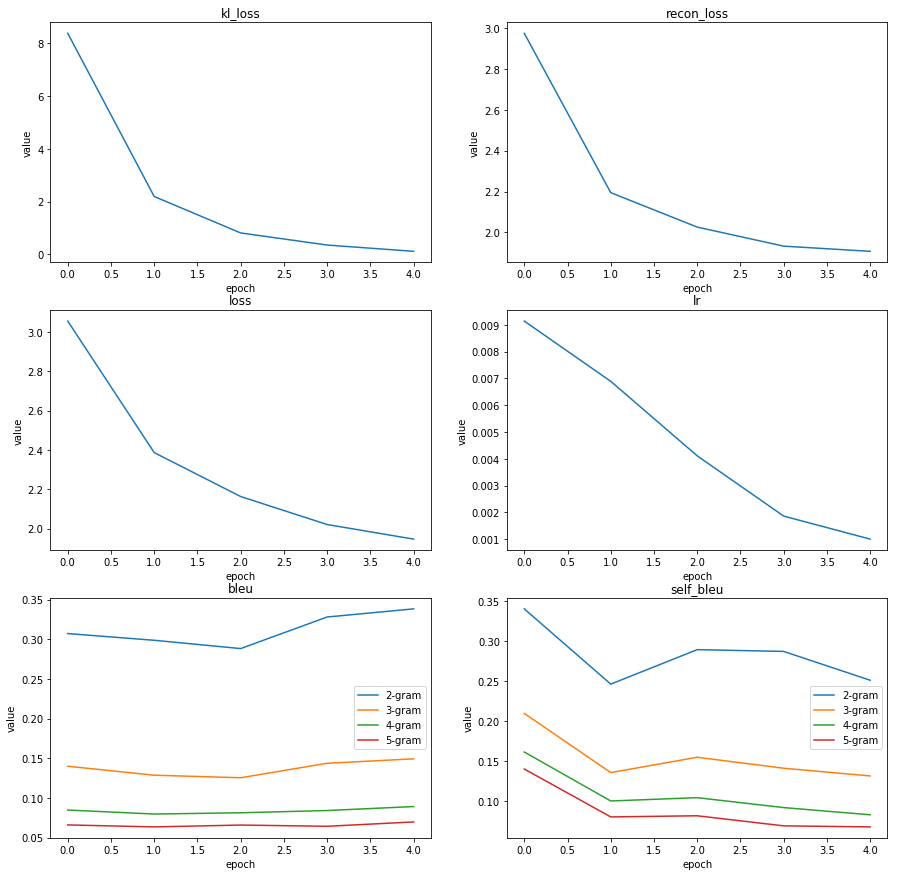

In [14]:
plotter = Plotter(elog)
plotter.grid([
    'kl_loss', 'recon_loss',
    'loss', 'lr',
    'bleu', 'self_bleu'
])

In [15]:
%time evaluator.bleu(model, args.train.bleu_test_hypot, 'train')

CPU times: user 1min 14s, sys: 10.7 ms, total: 1min 14s
Wall time: 1min 14s


{'2-gram': 0.8919798105486515,
 '3-gram': 0.64413336843458535,
 '4-gram': 0.42511642478038519,
 '5-gram': 0.30481452024849104}

In [16]:
%time evaluator.bleu(model, args.train.bleu_test_hypot, 'test')

CPU times: user 20.2 s, sys: 11.2 ms, total: 20.2 s
Wall time: 20.2 s


{'2-gram': 0.39064323157909875,
 '3-gram': 0.16188557971520123,
 '4-gram': 0.094443849645208744,
 '5-gram': 0.070593768046808489}

In [17]:
evaluator.self_bleu(model, args.train.bleu_test_hypot)

{'2-gram': 0.24585305159284021,
 '3-gram': 0.10708780487814559,
 '4-gram': 0.067093866153208795,
 '5-gram': 0.054102266164599809}

In [18]:
torch.save((args, model), path.save)

In [19]:
!du -sh {path.save}

3.2M	vae.pt
